# Vertex Tabular Binary Classification with .HyperparameterTuningJob()

<center><img src="../images/03.png"/></center>

## Set Constants

In [1]:
PROJECT_ID = 'jchavezar-demo'
REGION = 'us-central1'
TRAIN_DATASET_URI = 'gs://vtx-datasets-public/ecommerce/train.csv'
VAL_DATASET_URI = 'gs://vtx-datasets-public/ecommerce/val.csv'
TEST_DATASET_URI = 'gs://vtx-datasets-public/ecommerce/test.csv'
MODEL_URI = 'gs://vtx-models/ecommerce/03cc'
STAGING_URI = 'gs://vtx-staging/ecommerce/03cc'
TRAIN_IMAGE_URI = f'gcr.io/{PROJECT_ID}/03cc-tf-hpt-xai-train:latest'
PREDICTION_IMAGE_URI = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-9:latest'
SERIES = '03cc'
EXPERIMENT_NAME = 'ecommerce-exp'
EPOCHS = 10
BATCH_SIZE = 100

## Create Folder Structure

```
source
     |  Dockerfile
     |
     └─── trainer
          |  train.py
          |

```

In [2]:
!rm -fr source
!mkdir -p source/trainer

## Create Python Source Distribution Files 

In [3]:
%%writefile source/trainer/train.py

import os
import time
import warnings
import argparse
import hypertune
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
warnings.filterwarnings('ignore')

################################### ARGUMENTS #######################################


parser = argparse.ArgumentParser()
parser.add_argument('--train_data_uri', help = 'dataset to train', type = str)
parser.add_argument('--val_data_uri',  help = 'val to train', type = str)
parser.add_argument('--test_data_uri', help = 'test to train', type = str)
parser.add_argument('--epochs', dest = 'epochs', default = 2, type = int, help = 'Number of Epochs')
parser.add_argument('--batch_size', dest = 'batch_size', default = 32, type = int, help = 'Batch Size')
parser.add_argument('--lr', dest='learning_rate', required=True, type=float, help='Learning Rate')
args = parser.parse_args()

train_df = pd.read_csv(args.train_data_uri)
val_df = pd.read_csv(args.val_data_uri)
test_df = pd.read_csv(args.test_data_uri)

################################### PREPROCESSING #######################################

## Convert pandas dataframe to tensor data (from GCS to TF.data.Data)
init_start = time.process_time()
def df_to_dataset(dataframe, shuffle=None):
    df = dataframe.copy()
    labels = df.pop('will_buy_on_return_visit')
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds
      
## Normalization / Standarization
def get_normalization_layer(name, dataset):
    start = time.process_time()
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    print(f'Normalization time for {name}: {time.process_time() - start}')
    return normalizer

# Performs feature-wise categorical encoding of inputs features
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    start = time.process_time()
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    print(f'Encoding time for {name}: {time.process_time() - start}')
    return lambda feature: encoder(index(feature))

batch_size = args.batch_size
train_ds = df_to_dataset(train_df)
val_ds = df_to_dataset(val_df)
test_ds = df_to_dataset(test_df)

## Identify Numerical and Categorical columns:
num_columns = ['latest_ecommerce_progress', 'time_on_site', 'pageviews']
cat_columns = ['source', 'medium', 'channel_grouping', 'device_category', 'country']
num_cat_columns = 'bounces'

all_inputs = []
encoded_features = []

# Numerical Features.
for header in num_columns:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)
    
# Categorical Features.
for header in cat_columns:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                 dataset=train_ds,
                                                 dtype='string',
                                                 max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

## Integer values into integer indices.
bounces_col = tf.keras.Input(shape=(1,), name=num_cat_columns, dtype='int64')

encoding_layer = get_category_encoding_layer(name=num_cat_columns,
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(bounces_col)
all_inputs.append(bounces_col)
encoded_features.append(encoded_age_col)

print(f'Total preprocessing time: {time.process_time() - init_start}')

#########################################################################################


################################### CREATE, COMPILE AND TRAIN MODEL #####################

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = args.learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])
################################## SETUP HYPERPARAMETER METRICS AND TRAIN #####################


history = model.fit(train_ds, epochs=args.epochs, validation_data=val_ds)
loss, accuracy = model.evaluate(test_ds)
print("acccuracy: ", accuracy)

hp_metric = history.history['val_accuracy'][-1]

hpt = hypertune.HyperTune()
hpt.report_hyperparameter_tuning_metric(
    hyperparameter_metric_tag='accuracy',
    metric_value=hp_metric,
    global_step=args.epochs)


################################### SAVE MODEL ##########################################

model.save(os.environ['AIP_MODEL_DIR'])

Writing source/trainer/train.py


In [4]:
%%writefile source/Dockerfile

FROM python:3.9.12

COPY . /

RUN pip install tensorflow && \
    pip install google-cloud-storage && \
    pip install pandas && \
    pip install gcsfs && \
    pip install cloudml-hypertune

ENTRYPOINT ["python", "trainer/train.py"]

Writing source/Dockerfile


In [5]:
!gcloud builds submit -t $TRAIN_IMAGE_URI source/.

Creating temporary tarball archive of 2 file(s) totalling 5.7 KiB before compression.
Uploading tarball of [source/.] to [gs://jchavezar-demo_cloudbuild/source/1669872999.300671-1130ab9e03e6468b9099e44a1e26558f.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/jchavezar-demo/locations/global/builds/de0361e4-eac4-48d0-8d29-c4bff9983662].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/de0361e4-eac4-48d0-8d29-c4bff9983662?project=569083142710 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "de0361e4-eac4-48d0-8d29-c4bff9983662"

FETCHSOURCE
Fetching storage object: gs://jchavezar-demo_cloudbuild/source/1669872999.300671-1130ab9e03e6468b9099e44a1e26558f.tgz#1669872999519927
Copying gs://jchavezar-demo_cloudbuild/source/1669872999.300671-1130ab9e03e6468b9099e44a1e26558f.tgz#1669872999519927...
/ [1 files][  2.2 KiB/  2.2 KiB]                                                
Operation completed over 1 ob

## Create Vertex Tensorboard

In [6]:
from google.cloud import aiplatform as aip

tb = aip.Tensorboard.list(filter=f"labels.series={SERIES}")
if tb:
    tb = tb[0]
else: 
    tb = aip.Tensorboard.create(display_name=SERIES, labels={'series' : f'{SERIES}'})

## Create Vertex Training from Code [HyperParameterTuninJob]

In [7]:
CMDARGS = [
    "--train_data_uri="+TRAIN_DATASET_URI,
    "--val_data_uri="+VAL_DATASET_URI,
    "--test_data_uri="+TEST_DATASET_URI,
    "--epochs=" + str(EPOCHS),
    "--batch_size=" + str(BATCH_SIZE),
]

MACHINE_SPEC = {
    "machine_type": "n1-standard-4",
    "accelerator_count": 0
}

WORKER_POOL_SPEC = [
    {
        "replica_count": 1,
        "machine_spec": MACHINE_SPEC,
        "container_spec": {
            "image_uri": TRAIN_IMAGE_URI,
            "command": [],
            "args": CMDARGS
        }
    }
]

In [8]:
customJob = aip.CustomJob(
    display_name = f'03cc-tfkeras-hpt-customjob',
    worker_pool_specs = WORKER_POOL_SPEC,
    base_output_dir = MODEL_URI,
    staging_bucket = STAGING_URI,
)

In [9]:
METRIC_SPEC = {
    "accuracy": "maximize"
}


PARAMETER_SPEC = {
    "lr": aip.hyperparameter_tuning.DoubleParameterSpec(min=0.001, max=0.1, scale="log"),
}

In [10]:
tuningJob = aip.HyperparameterTuningJob(
    display_name = f'03cc-tfkeras-hpt-customjob',
    custom_job = customJob,
    metric_spec = METRIC_SPEC,
    parameter_spec = PARAMETER_SPEC,
    max_trial_count = 18,
    parallel_trial_count = 3,
    search_algorithm = None,
)

In [11]:
tuningJob.run(
    service_account = 'vtx-pipe@jchavezar-demo.iam.gserviceaccount.com',
    tensorboard = tb.resource_name
)

Creating HyperparameterTuningJob
HyperparameterTuningJob created. Resource name: projects/569083142710/locations/us-central1/hyperparameterTuningJobs/7092782522454507520
To use this HyperparameterTuningJob in another session:
hpt_job = aiplatform.HyperparameterTuningJob.get('projects/569083142710/locations/us-central1/hyperparameterTuningJobs/7092782522454507520')
View HyperparameterTuningJob:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/7092782522454507520?project=569083142710
View Tensorboard:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+569083142710+locations+us-central1+tensorboards+2851139203939434496+experiments+7092782522454507520
HyperparameterTuningJob projects/569083142710/locations/us-central1/hyperparameterTuningJobs/7092782522454507520 current state:
JobState.JOB_STATE_PENDING
HyperparameterTuningJob projects/569083142710/locations/us-central1/hyperparameterTuningJobs/7092782522454507520 current state:
JobState.JO

## Get Model Information from Tensorflow Graph

2022-12-01 06:40:28.562984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 06:40:30.351348: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-01 06:40:30.351621: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

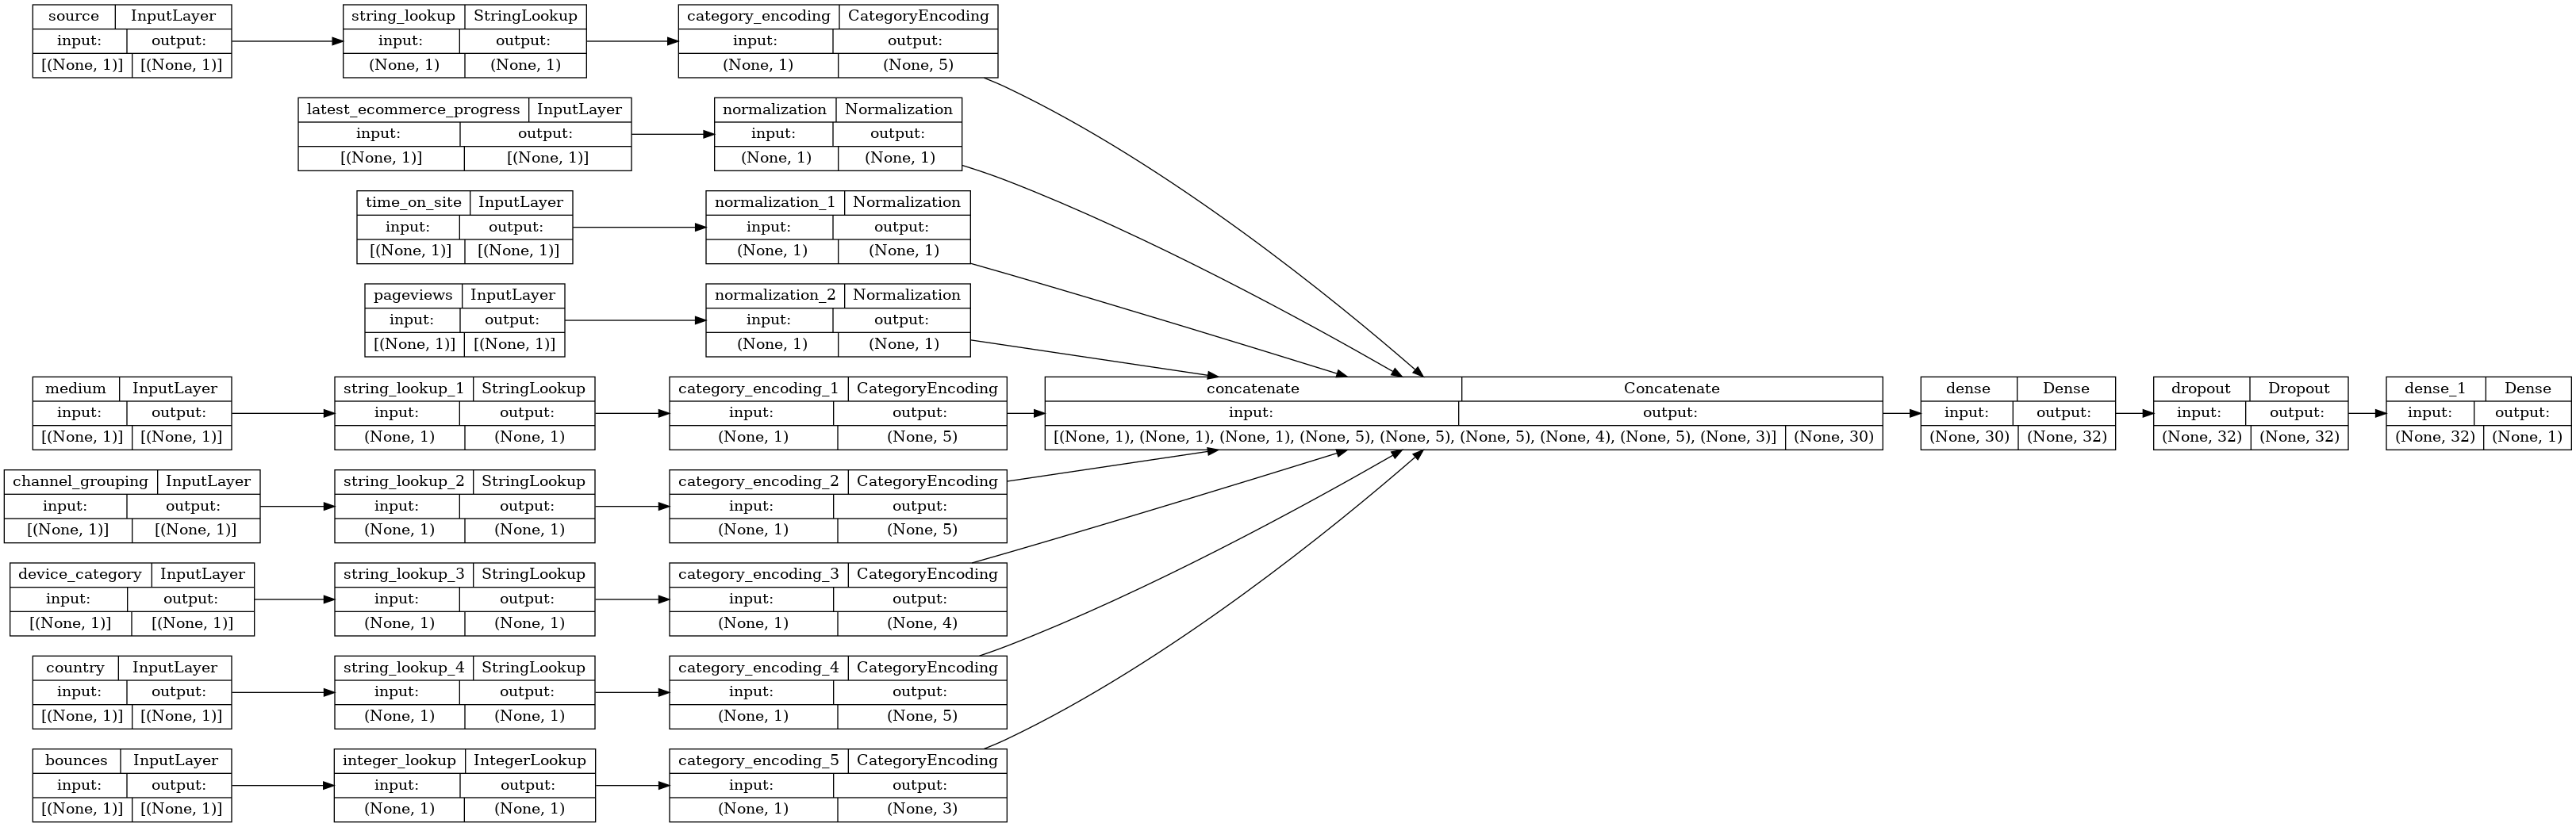

In [12]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

loaded_model = tf.keras.models.load_model(f"{MODEL_URI}/1/model")
tf.keras.utils.plot_model(loaded_model, show_shapes=True, rankdir="LR")

## Build Explainable AI Metadata from Graph

In [13]:
infer = loaded_model.signatures['serving_default']
print(infer.inputs)
print()
print(infer.structured_outputs)

[<tf.Tensor 'bounces:0' shape=(None, 1) dtype=int64>, <tf.Tensor 'channel_grouping:0' shape=(None, 1) dtype=string>, <tf.Tensor 'country:0' shape=(None, 1) dtype=string>, <tf.Tensor 'device_category:0' shape=(None, 1) dtype=string>, <tf.Tensor 'latest_ecommerce_progress:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'medium:0' shape=(None, 1) dtype=string>, <tf.Tensor 'pageviews:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'source:0' shape=(None, 1) dtype=string>, <tf.Tensor 'time_on_site:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'unknown:0' shape=() dtype=resource>, <tf.Tensor 'unknown_0:0' shape=() dtype=int64>, <tf.Tensor 'unknown_1:0' shape=() dtype=resource>, <tf.Tensor 'unknown_2:0' shape=() dtype=int64>, <tf.Tensor 'unknown_3:0' shape=() dtype=resource>, <tf.Tensor 'unknown_4:0' shape=() dtype=int64>, <tf.Tensor 'unknown_5:0' shape=() dtype=resource>, <tf.Tensor 'unknown_6:0' shape=() dtype=int64>, <tf.Tensor 'unknown_7:0' shape=() dtype=resource>, <tf.Tensor 'unknown_8:0' s

In [14]:
EXPLANATION_METADATA = {
    "outputs": {
        "logit": { 
            "output_tensor_name": "dense_1"
        }
    },
    "inputs": { 
        "latest_ecommerce_progress": {},
        "bounces": {},
        "time_on_site": {},
        "pageviews": {},
        "source": {},
        "medium": {},
        "channel_grouping": {},
        "device_category": {},
        "country": {},
    }
}
EXPLANATION_PARAMS = {"sampled_shapley_attribution": {"path_count": 5}}

## Upload Model

In [15]:
model = aip.Model.upload(
    display_name = 'ecommerce_tf',
    serving_container_image_uri = PREDICTION_IMAGE_URI,
    artifact_uri = f'{MODEL_URI}/1/model',
    explanation_parameters=EXPLANATION_PARAMS,
    explanation_metadata=EXPLANATION_METADATA,
)

Creating Model
Create Model backing LRO: projects/569083142710/locations/us-central1/models/7121600584779563008/operations/5919668692961984512
Model created. Resource name: projects/569083142710/locations/us-central1/models/7121600584779563008@1
To use this Model in another session:
model = aiplatform.Model('projects/569083142710/locations/us-central1/models/7121600584779563008@1')


## Deploy Model On Endpoint

In [16]:
endpoint = model.deploy(
    deployed_model_display_name = 'ecommerce_tf_ep_dep',
    traffic_percentage = 100,
    machine_type = 'n1-standard-4',
    min_replica_count = 1,
    max_replica_count = 1,
    explanation_metadata=EXPLANATION_METADATA,
    explanation_parameters=EXPLANATION_PARAMS
)

Creating Endpoint
Create Endpoint backing LRO: projects/569083142710/locations/us-central1/endpoints/232397175693246464/operations/3491665543855865856
Endpoint created. Resource name: projects/569083142710/locations/us-central1/endpoints/232397175693246464
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/569083142710/locations/us-central1/endpoints/232397175693246464')
Deploying model to Endpoint : projects/569083142710/locations/us-central1/endpoints/232397175693246464
Deploy Endpoint model backing LRO: projects/569083142710/locations/us-central1/endpoints/232397175693246464/operations/2188436401685528576
Endpoint model deployed. Resource name: projects/569083142710/locations/us-central1/endpoints/232397175693246464


## Testing Predictions

In [17]:
instance = {
    'latest_ecommerce_progress': [0],
    'bounces': [0],
    'time_on_site': [103],
    'pageviews': [3],
    'source': ['youtube.com'],
    'medium': ['referral'],
    'channel_grouping': ['Social'],
    'device_category': ['desktop'],
    'country': ['Vietnam'],
}

In [18]:
endpoint.predict([instance])

Prediction(predictions=[[-30.1842022]], deployed_model_id='2144430304209666048', model_version_id='1', model_resource_name='projects/569083142710/locations/us-central1/models/7121600584779563008', explanations=None)

In [19]:
explanations = endpoint.explain([instance])
print("Explainable predictions:", explanations)

Explainable predictions: Prediction(predictions=[[-30.1842022]], deployed_model_id='2144430304209666048', model_version_id=None, model_resource_name=None, explanations=[attributions {
  baseline_output_value: -11.508017539978027
  instance_output_value: -30.184200286865234
  feature_attributions {
    struct_value {
      fields {
        key: "bounces"
        value {
          list_value {
            values {
              number_value: 0.0
            }
          }
        }
      }
      fields {
        key: "channel_grouping"
        value {
          list_value {
            values {
              number_value: -3.745048999786377
            }
          }
        }
      }
      fields {
        key: "country"
        value {
          list_value {
            values {
              number_value: -10.83785781860352
            }
          }
        }
      }
      fields {
        key: "device_category"
        value {
          list_value {
            values {
              n

<BarContainer object of 9 artists>

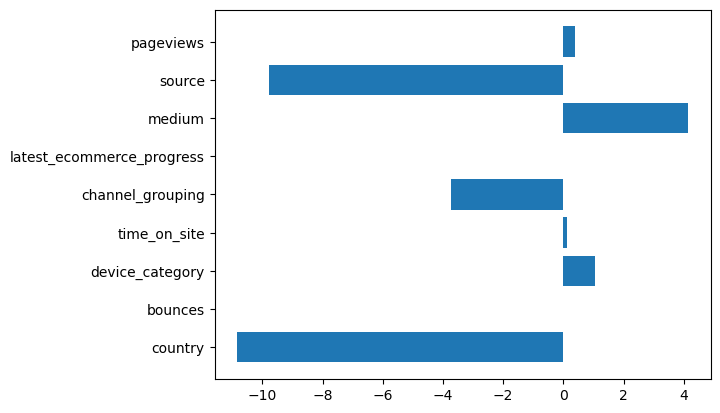

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

results = {k:v for k,v in explanations[4][0].attributions[0].feature_attributions.items()}
names = list(results.keys())
values = []
for i in results.values():
    values.append(i.pop())
    
plt.barh(range(len(results)), values, tick_label=names)

## Cleaning

In [21]:
!rm -f source.tar source.tar.gz
!rm -fr source